In [1]:
from pathlib import Path

data_dir = Path.cwd() / "data"
assert data_dir.exists(), f"Data directory does not exist: {data_dir}"

In [ ]:
import json
from copy import copy

import numpy as np
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

from rich.progress import track

In [ ]:
# Set Times New Roman font and larger font sizes for presentations
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
sns.set_context('talk')
sns.set_style('whitegrid')

In [3]:
first = json.loads(
    (data_dir / "Versuch_V4_T2_A1_Dec-18-25__19_26.json").read_text())

In [4]:
len(first)

500

In [5]:
first[0].keys()

dict_keys(['meta_data', 'expert_knowledge', 'data'])

In [6]:
first[0]["meta_data"]

{'dataset': 'SPP2422_experiment_tdms',
 'origin': 'experiment',
 'program': 'LabVIEW/NI TDMS',
 'description': 'TDMS measurement V4_T2_A1 | file=Versuch_V4_T2_A1_Dec-18-25__19_26.tdms',
 'created_utc': '2026-01-11T12:39:38.292358Z',
 'source_file': 'Versuch_V4_T2_A1_Dec-18-25__19_26.tdms',
 'group_name': 'Messergebnisse_V4_T2_A1',
 'V': 4,
 'T': 2,
 'A': 1,
 'export': {'target_length': 1200, 'max_hubs_per_file': None},
 'channel_mapping': {'K1_Ch1_Mod2/AI0': 'K1_Ch1_Mod2__AI0',
  'K1_Ch2_Mod2/AI1': 'K1_Ch2_Mod2__AI1',
  'K1_Ch3_Mod2/AI2': 'K1_Ch3_Mod2__AI2',
  'K2_Ch1_Mod2/AI3': 'K2_Ch1_Mod2__AI3',
  'K2_Ch2_Mod2/AI4': 'K2_Ch2_Mod2__AI4',
  'K2_Ch3_Mod2/AI5': 'K2_Ch3_Mod2__AI5',
  'K3_Ch1_Mod2/AI6': 'K3_Ch1_Mod2__AI6',
  'K3_Ch2_Mod2/AI7': 'K3_Ch2_Mod2__AI7',
  'K3_Ch3_Mod2/AI8': 'K3_Ch3_Mod2__AI8',
  'Mod2/AI9': 'Mod2__AI9',
  'Mod7 A0': 'Mod7_A0',
  'Mod7 A1': 'Mod7_A1',
  'Mod7 A2': 'Mod7_A2',
  'Mod7 A3': 'Mod7_A3'},
 'hub_index': 1,
 'hub_range_samples': [197, 10453],
 'stroke': 0

In [7]:
first[0]["expert_knowledge"]

[{'textual_insight': '', 'extracted_features': {}}]

In [8]:
first[0]["data"].keys()

dict_keys(['name', 'label', 'label_unit', 'level', 'origin', 'i.O/n.i.O', 'time_s', 'signals'])

In [9]:
simpler = copy(first[0]["data"])
del simpler["time_s"]
del simpler["signals"]
simpler

{'name': 'Versuch_V4_T2_A1_Dec-18-25__19_26__hub0001',
 'label': None,
 'label_unit': None,
 'level': 1,
 'origin': 'experiment',
 'i.O/n.i.O': None}

In [10]:
t = np.array(first[0]["data"]["time_s"])
t.shape, [t.min().item(), t.mean().item(), t.max().item()]

((1200,), [0.0, 0.5, 1.0])

In [11]:
first[0]["data"]["signals"].keys()

dict_keys(['K1_Ch1_Mod2__AI0', 'K1_Ch2_Mod2__AI1', 'K1_Ch3_Mod2__AI2', 'K2_Ch1_Mod2__AI3', 'K2_Ch2_Mod2__AI4', 'K2_Ch3_Mod2__AI5', 'K3_Ch1_Mod2__AI6', 'K3_Ch2_Mod2__AI7', 'K3_Ch3_Mod2__AI8', 'Mod2__AI9', 'Mod7_A0', 'Mod7_A1', 'Mod7_A2', 'Mod7_A3'])

In [12]:
s = np.array(first[0]["data"]["signals"]["K1_Ch1_Mod2__AI0"])
s.shape, [s.min().item(), s.mean().item(), s.max().item()]

((1200,), [-0.09008782699368648, 0.4326112404590785, 6.710733563229876])

In [13]:
agg = []

# We iterate over all files in the data directory and collect all data
for file_path in track(list(data_dir.glob("Versuch_*.json")), description="Loading data files"):
    data = json.loads(file_path.read_text())

    for i, data_entry in enumerate(data):
        meta_data = {
            "Versuch": file_path.stem,
            "index": i,
            "V": data_entry["meta_data"]["V"],
            "T": data_entry["meta_data"]["T"],
            "A": data_entry["meta_data"]["A"],
        }
        if meta_data["T"] == 0 or meta_data["A"] == 0:
            # Skip invalid entries
            continue

        agg.append({
            "meta_data": meta_data,
            "data": {
                key: np.array(value)
                for key, value in {
                    "time_s": data_entry["data"]["time_s"],
                    **data_entry["data"]["signals"]
                }.items()
            }
        })

# Get signal keys from first entry
signal_keys = list(agg[0]["data"].keys())
n_entries = len(agg)
n_points = len(agg[0]["data"]["time_s"])

print(f"Number of entries: {n_entries}")
print(f"Number of time points per entry: {n_points}")
print(f"Number of signals: {len(signal_keys)}")

Output()

Number of entries: 4500
Number of time points per entry: 1200
Number of signals: 15


In [14]:
# Stack all data into single arrays
# Shape: (n_entries, n_signals, n_points)
data_array = np.stack([
    np.stack([entry["data"][key] for key in signal_keys])
    for entry in agg
])

# Metadata arrays
versuch_array = np.array([entry["meta_data"]["Versuch"]
                         for entry in agg], dtype="S64")
index_array = np.array([entry["meta_data"]["index"]
                       for entry in agg], dtype=np.int32)
v_array = np.array([entry["meta_data"]["V"] for entry in agg], dtype=np.int32)
# T = Tiefziehen (Deep Drawing)
deep_drawing_array = np.array([entry["meta_data"]["T"]
                              for entry in agg], dtype=np.int32)
# A = Abstrecken (Ironing)
ironing_array = np.array([entry["meta_data"]["A"]
                         for entry in agg], dtype=np.int32)

print(f"Data array shape: {data_array.shape}")

Data array shape: (4500, 15, 1200)


In [15]:
diffs = np.diff(data_array[:, 0, :], axis=-1).flatten()
print(f"Differences min:  {diffs.min().item()}")
print(f"Differences max:  {diffs.max().item()}")
print(f"Differences mean: {diffs.mean().item()}")

assert diffs.min() > (1-1e-6) * abs(diffs.mean()), "irregular sampling detected"
assert diffs.max() < (1+1e-6) * abs(diffs.mean()), "irregular sampling detected"

Differences min:  0.0008340283569641116
Differences max:  0.0008340283569642226
Differences mean: 0.0008340283569641367


T/A combinations: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]


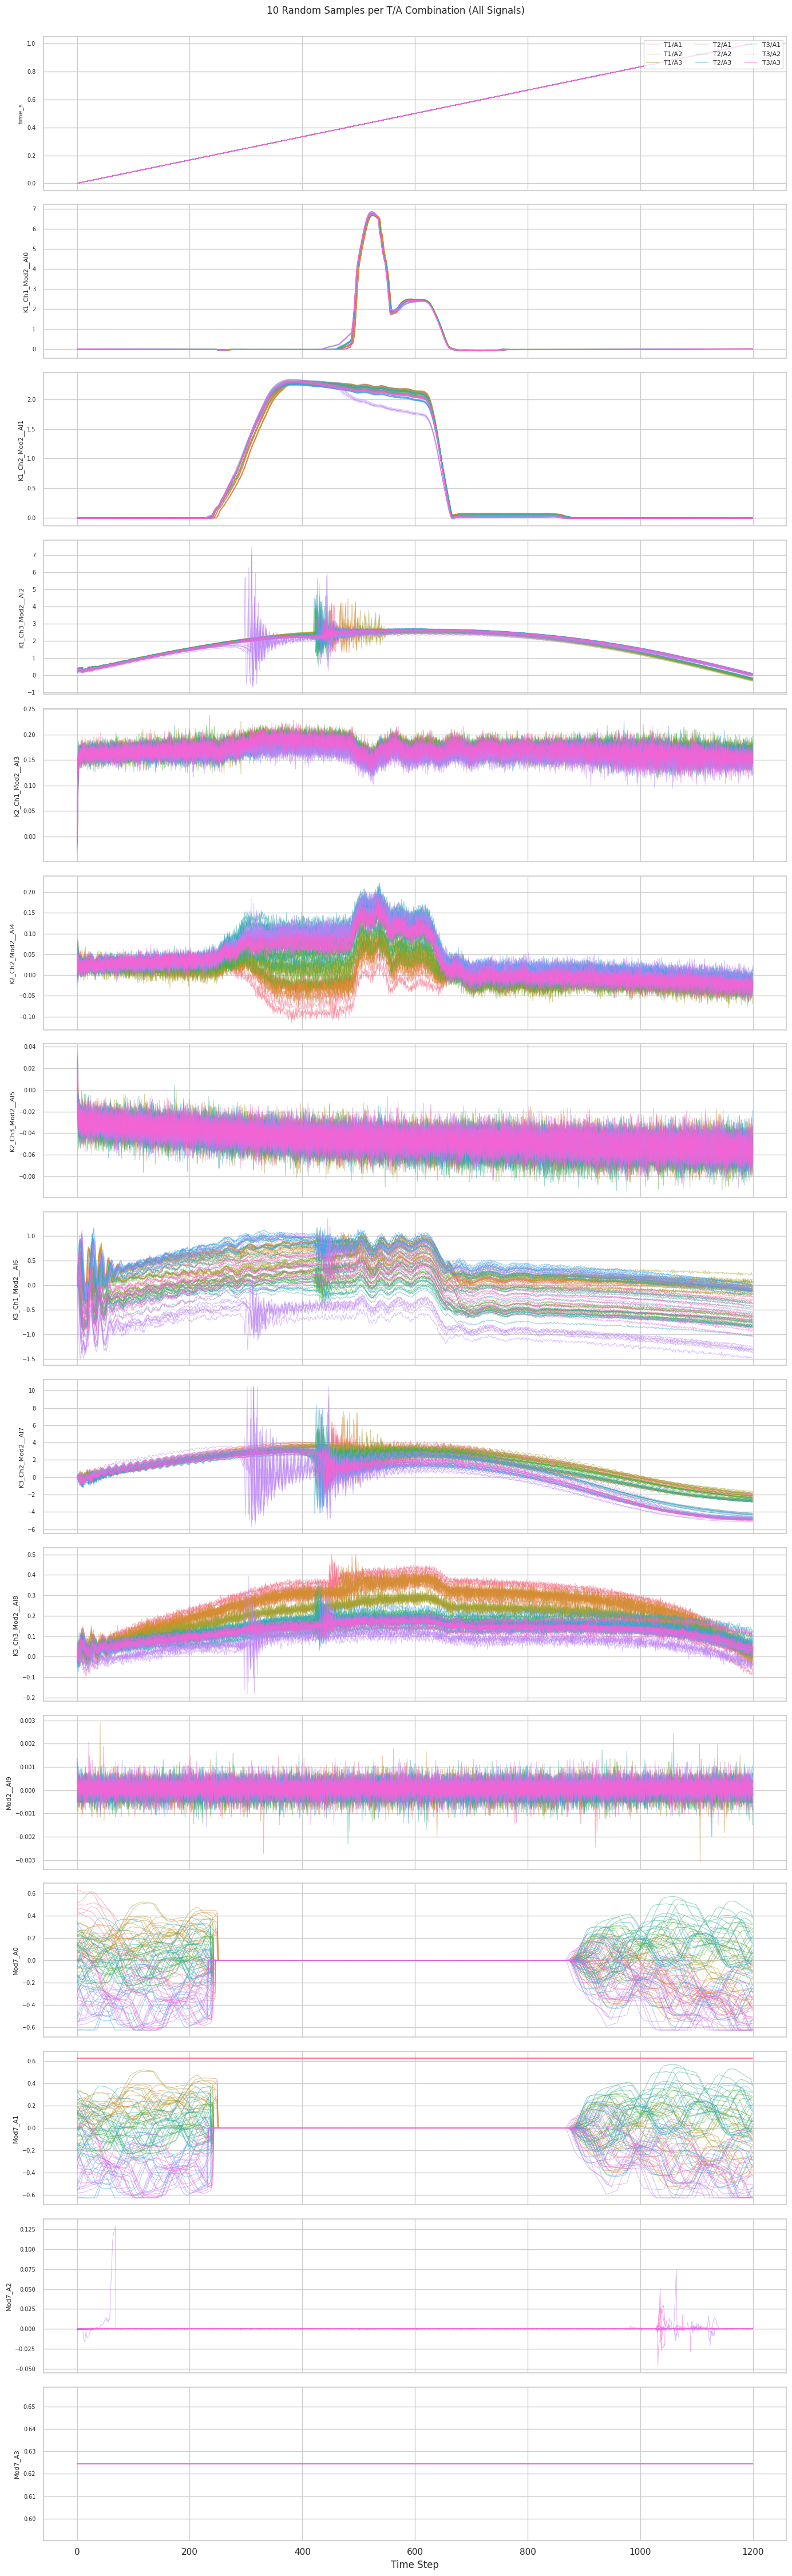

In [16]:
def plot_samples_by_ta(data_array: np.ndarray, deep_drawing_array: np.ndarray, 
                       ironing_array: np.ndarray, plot_signal_keys: list,
                       samples_per_combo: int = 10, seed: int = 42):
    """
    Plot random samples from each T/A combination, color coded.
    
    Args:
        data_array: Shape (n_samples, n_signals, n_timepoints)
        deep_drawing_array: T values for each sample
        ironing_array: A values for each sample
        plot_signal_keys: List of signal key names
        samples_per_combo: Number of random samples to plot per T/A combination
        seed: Random seed for reproducibility
    """
    sns.set_theme(style="whitegrid")

    # Get unique T/A combinations (convert to plain ints for readability)
    ta_combinations = sorted(set((int(t), int(a)) for t, a in zip(deep_drawing_array, ironing_array)))
    print(f"T/A combinations: {ta_combinations}")

    # Create a color palette for T/A combinations
    n_combinations = len(ta_combinations)
    palette = sns.color_palette("husl", n_combinations)
    ta_to_color = {ta: palette[i] for i, ta in enumerate(ta_combinations)}

    # Group sample indices by T/A combination
    ta_to_indices = {ta: [] for ta in ta_combinations}
    for idx, (t, a) in enumerate(zip(deep_drawing_array, ironing_array)):
        ta_to_indices[(int(t), int(a))].append(idx)

    # Sample random indices from each T/A combination
    np.random.seed(seed)
    sampled_indices = {}
    for ta, indices in ta_to_indices.items():
        if len(indices) >= samples_per_combo:
            sampled_indices[ta] = np.random.choice(indices, samples_per_combo, replace=False)
        else:
            sampled_indices[ta] = indices

    # Get signal keys (excluding time_s)
    n_signals = len(plot_signal_keys)
    n_timepoints = data_array.shape[2]
    time_steps = np.arange(n_timepoints)

    # Create figure with subplots for each signal
    fig, axes = plt.subplots(n_signals, 1, figsize=(14, 3 * n_signals), sharex=True)
    if n_signals == 1:
        axes = [axes]

    for ax, (signal_idx, signal_key) in zip(axes, enumerate(plot_signal_keys)):
        for ta, indices in sampled_indices.items():
            color = ta_to_color[ta]
            label = f"T{ta[0]}/A{ta[1]}"
            for i, idx in enumerate(indices):
                signal_data = data_array[idx, signal_idx, :]
                ax.plot(time_steps, signal_data, color=color, alpha=0.5, linewidth=0.8,
                       label=label if i == 0 else None)
        
        ax.set_ylabel(signal_key, fontsize=8)
        ax.tick_params(axis='y', labelsize=7)

    axes[0].legend(loc='upper right', fontsize=8, ncol=3)
    axes[-1].set_xlabel("Time Step")

    plt.suptitle(f"{samples_per_combo} Random Samples per T/A Combination (All Signals)", fontsize=12, y=1.0)
    plt.tight_layout()
    plt.show()

# Call the function with current data
plot_samples_by_ta(data_array, deep_drawing_array, ironing_array, signal_keys)

In [17]:
# Compute onset times for K1_Ch1_Mod2__AI0 signal at multiple thresholds
# Onset = first time the absolute value goes above threshold

signal_name = "K1_Ch1_Mod2__AI0"
signal_idx = signal_keys.index(signal_name)
thresholds = [2, 3, 4, 5, 6]

n_samples = data_array.shape[0]
n_timepoints = data_array.shape[2]
time = np.linspace(0, 1, n_timepoints)
time_step = time[1] - time[0]

# Compute onset times for each threshold
# Shape: (n_samples, n_thresholds)
onset_times_all = np.full((n_samples, len(thresholds)), np.nan)

for i in range(n_samples):
    signal = data_array[i, signal_idx, :]
    for j, threshold in enumerate(thresholds):
        crossings = np.where(np.abs(signal) > threshold)[0]
        if len(crossings) > 0:
            onset_times_all[i, j] = time[crossings[0]]

# Compute global average onset time for each threshold
global_avg_onsets = np.nanmean(onset_times_all, axis=0)
print(f"Signal: {signal_name}")
print(f"Global average onset times by threshold:")
for thresh, avg in zip(thresholds, global_avg_onsets):
    print(f"  Threshold {thresh}: {avg:.4f} s")

# Compute per-sample shifts from global average for each threshold
# Shape: (n_samples, n_thresholds)
onset_shifts = onset_times_all - global_avg_onsets

# Average shift across all 6 thresholds per sample
avg_shift_per_sample = np.nanmean(onset_shifts, axis=1)

# Measure of disagreement: std dev of the 6 shifts per sample
shift_std_per_sample = np.nanstd(onset_shifts, axis=1)

print(f"\nShift statistics:")
print(f"  Mean of average shifts: {np.nanmean(avg_shift_per_sample):.6f} s")
print(f"  Std of average shifts: {np.nanstd(avg_shift_per_sample):.6f} s")
print(f"\nDisagreement between thresholds (std of 6 shifts per sample):")
print(f"  Time step: {time_step:.6f} s ({time_step*1000:.3f} ms)")
print(f"  Mean disagreement: {np.nanmean(shift_std_per_sample):.6f} s ({np.nanmean(shift_std_per_sample)/time_step:.1f} time steps)")
print(f"  Max disagreement: {np.nanmax(shift_std_per_sample):.6f} s ({np.nanmax(shift_std_per_sample)/time_step:.1f} time steps)")
print(f"  Min disagreement: {np.nanmin(shift_std_per_sample):.6f} s ({np.nanmin(shift_std_per_sample)/time_step:.1f} time steps)")

Signal: K1_Ch1_Mod2__AI0
Global average onset times by threshold:
  Threshold 2: 0.4115 s
  Threshold 3: 0.4135 s
  Threshold 4: 0.4156 s
  Threshold 5: 0.4204 s
  Threshold 6: 0.4266 s

Shift statistics:
  Mean of average shifts: 0.000000 s
  Std of average shifts: 0.000996 s

Disagreement between thresholds (std of 6 shifts per sample):
  Time step: 0.000834 s (0.834 ms)
  Mean disagreement: 0.000264 s (0.3 time steps)
  Max disagreement: 0.000562 s (0.7 time steps)
  Min disagreement: 0.000202 s (0.2 time steps)


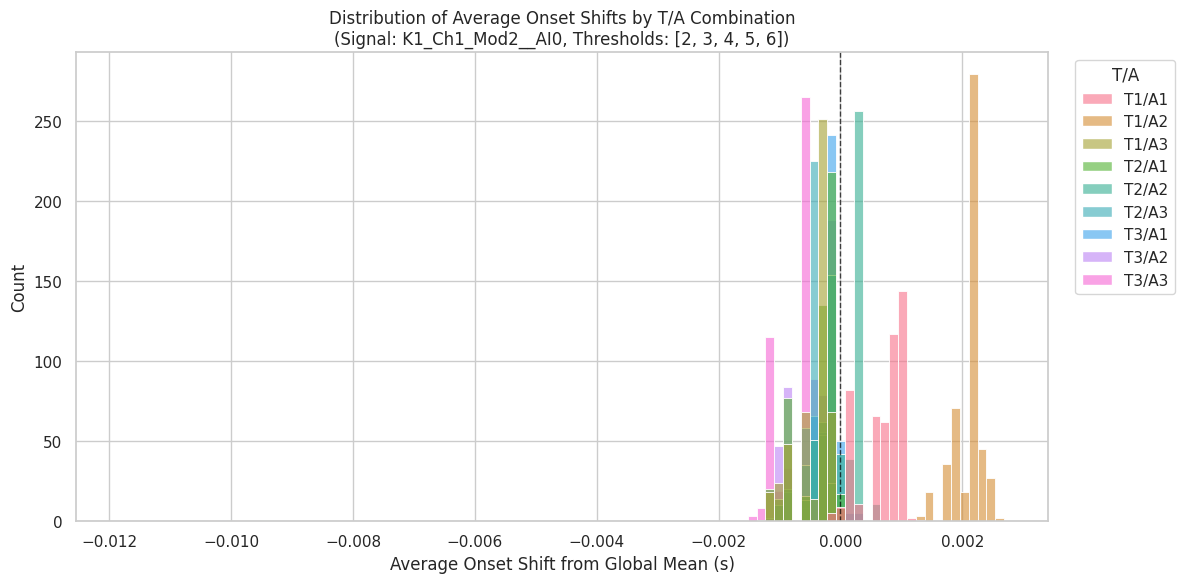

In [18]:
# Plot histogram of average onset shifts, color coded by T/A combination
import pandas as pd

# Create DataFrame for seaborn
df = pd.DataFrame({
    'avg_shift': avg_shift_per_sample,
    'shift_std': shift_std_per_sample,
    'T': deep_drawing_array,
    'A': ironing_array,
})
df['T/A'] = [f"T{int(t)}/A{int(a)}" for t, a in zip(df['T'], df['A'])]

# Remove samples with NaN shifts
df_valid = df.dropna(subset=['avg_shift'])

# Plot histogram
fig, ax = plt.subplots(figsize=(12, 6))

ta_order = [f"T{t}/A{a}" for t in [1, 2, 3] for a in [1, 2, 3]]
palette = sns.color_palette("husl", len(ta_order))

sns.histplot(
    data=df_valid,
    x='avg_shift',
    hue='T/A',
    hue_order=ta_order,
    palette=palette,
    bins=100,
    stat='count',
    common_norm=False,
    alpha=0.6,
    ax=ax
)

ax.set_xlabel("Average Onset Shift from Global Mean (s)")
ax.set_ylabel("Count")
ax.set_title(f"Distribution of Average Onset Shifts by T/A Combination\n(Signal: {signal_name}, Thresholds: {thresholds})")
ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

# Move legend outside
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1), title="T/A")

plt.tight_layout()
plt.show()

In [19]:
# Create time-aligned data array by shifting each sample to align onsets
# Cut 50 time steps from start and end as buffer for shifting

buffer = 50
new_length = n_timepoints - 2 * buffer  # 1100 time points

# Convert average shift to time steps (negative because we compensate)
shift_in_steps = np.round(avg_shift_per_sample / time_step).astype(int)

print(f"Avg. shift range: {shift_in_steps.mean():.6f} time steps")
print(f"Shift range: [{shift_in_steps.min()}, {shift_in_steps.max()}] time steps")
print(f"Buffer: {buffer} time steps on each side")
print(f"New time series length: {new_length} (was {n_timepoints})")

# Create aligned data array
# Shape: (n_samples, n_signals, new_length)
data_array_aligned = np.zeros((n_samples, data_array.shape[1], new_length))

for i in range(n_samples):
    # If sample onset is later than average (positive shift), start later in original
    # If sample onset is earlier than average (negative shift), start earlier in original
    start_idx = buffer + shift_in_steps[i]
    end_idx = start_idx + new_length
    
    # Ensure we stay within bounds
    start_idx = max(0, min(start_idx, n_timepoints - new_length))
    end_idx = start_idx + new_length
    
    data_array_aligned[i] = data_array[i, :, start_idx:end_idx]

print(f"Aligned data array shape: {data_array_aligned.shape}")

Avg. shift range: 0.032222 time steps
Shift range: [-14, 3] time steps
Buffer: 50 time steps on each side
New time series length: 1100 (was 1200)
Aligned data array shape: (4500, 15, 1100)


T/A combinations: [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]


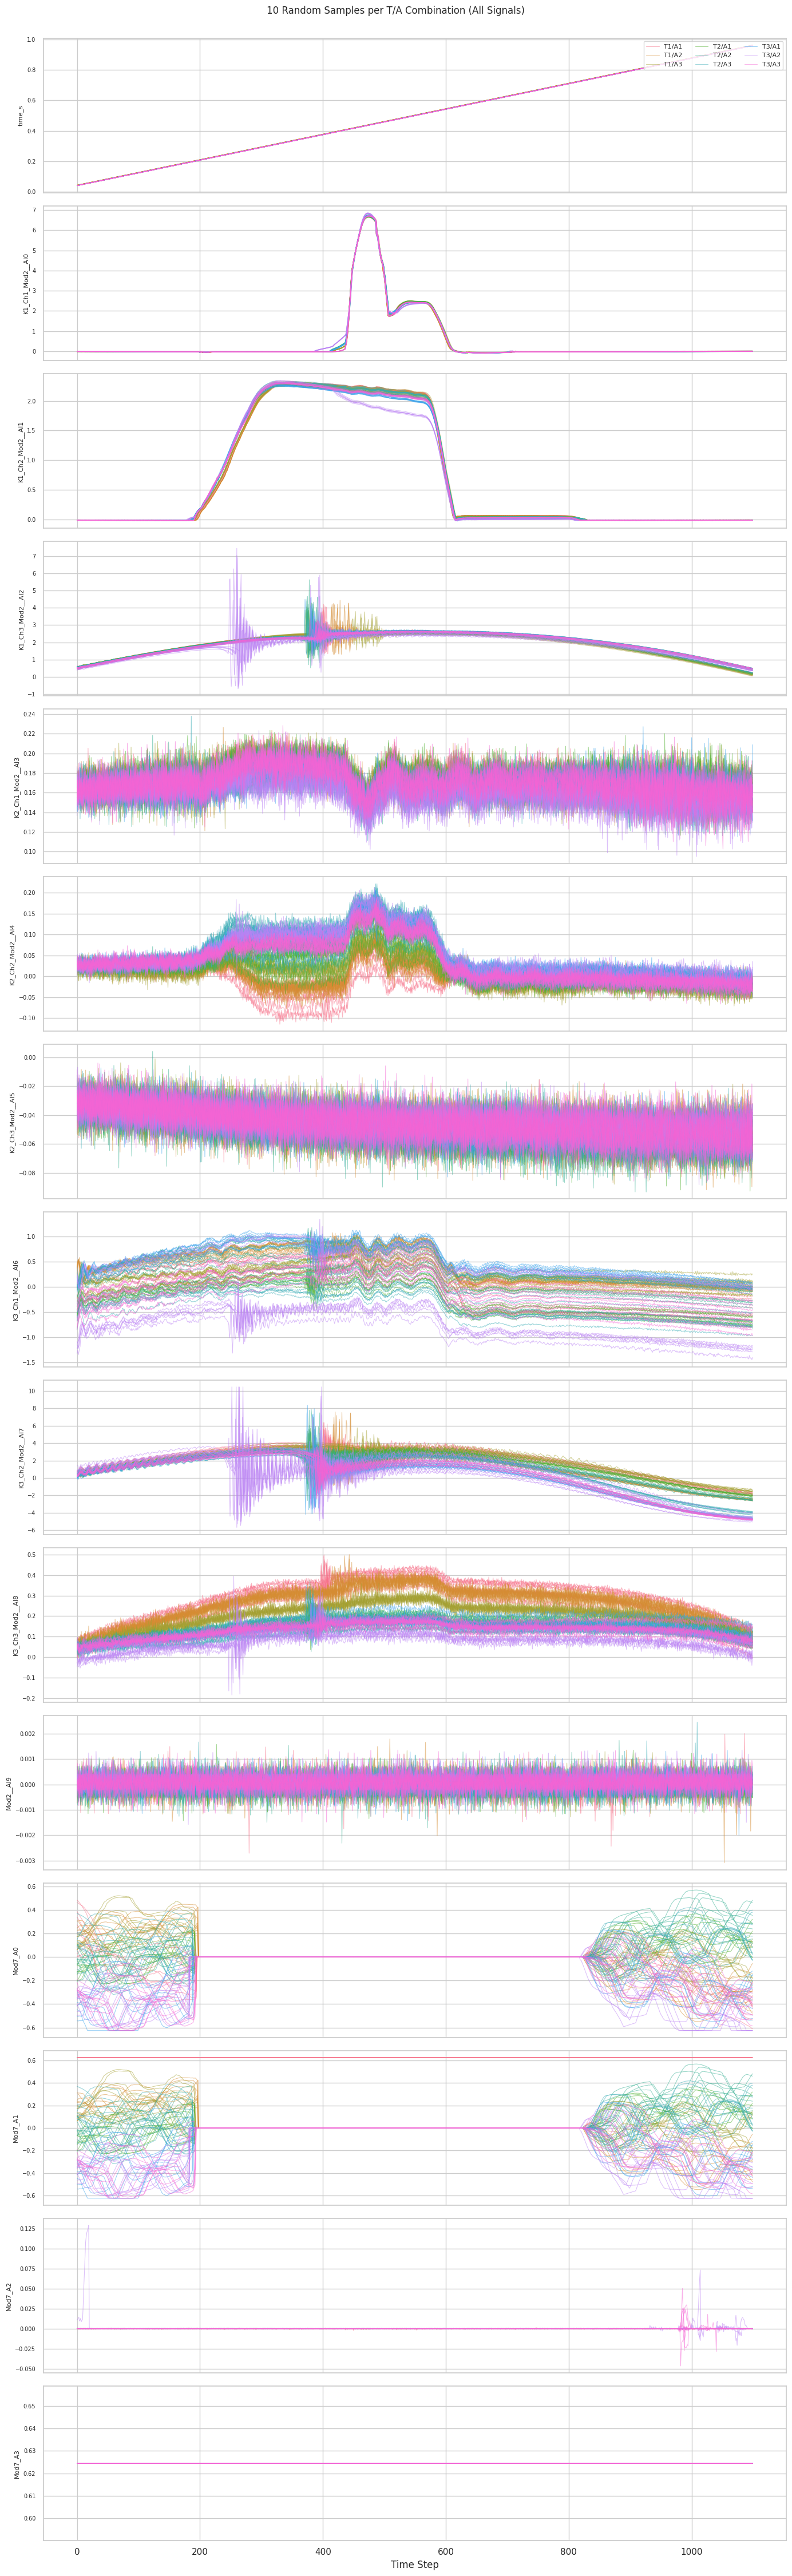

In [20]:
# Plot aligned signals by T/A combination
plot_samples_by_ta(data_array_aligned, deep_drawing_array, ironing_array, signal_keys)

In [21]:
# Dump aligned data into an HDF5 file for easier access later
with h5py.File(data_dir / "all_data.hdf5", "w") as h5f:
    # Store signal data as single dataset (aligned, 1100 time steps)
    h5f.create_dataset("data", data=data_array_aligned, compression="gzip")

    # Store signal names as attribute (excluding time_s)
    h5f["data"].attrs["signal_keys"] = [k.encode() for k in signal_keys if k != "time_s"]

    # Store metadata as datasets
    meta_grp = h5f.create_group("meta_data")
    meta_grp.create_dataset("index", data=index_array)
    meta_grp.create_dataset("Versuch", data=versuch_array)
    meta_grp.create_dataset("V", data=v_array)
    meta_grp.create_dataset("Deep Drawing", data=deep_drawing_array)
    meta_grp.create_dataset("Ironing", data=ironing_array)

In [22]:
# Print the file size
h5_file_size = (data_dir / "all_data.hdf5").stat().st_size / (1024 ** 2)
print(f"HDF5 file size: {h5_file_size:.2f} MB")

HDF5 file size: 405.77 MB


In [23]:
# Verify that we can read back the data correctly
with h5py.File(data_dir / "all_data.hdf5", "r") as h5f:
    read_data = h5f["data"][:]
    read_signal_keys = [k for k in h5f["data"].attrs["signal_keys"]]

    assert np.array_equal(data_array_aligned, read_data), "Data mismatch"
    assert read_signal_keys == [k for k in signal_keys if k != "time_s"], "Signal keys mismatch"
    assert np.array_equal(h5f["meta_data/Versuch"][:],
                          versuch_array), "Versuch mismatch"
    assert np.array_equal(h5f["meta_data/V"][:], v_array), "V mismatch"
    # T = Tiefziehen (Deep Drawing)
    assert np.array_equal(h5f["meta_data/Deep Drawing"][:],
                          deep_drawing_array), "Deep Drawing mismatch"
    # A = Abstrecken (Ironing)
    assert np.array_equal(h5f["meta_data/Ironing"][:],
                          ironing_array), "Ironing mismatch"

print(f"HDF5 file verified successfully.")
print(f"Data shape: {read_data.shape}")

del agg, data_array  # Free memory

HDF5 file verified successfully.
Data shape: (4500, 15, 1100)
